# Title - Cartoonify
### Authors: Wiktoria Uramowska, Hung-Chuan Huang, Hongxiang Qi

## Approaches:

OpenCV [1]
Improve the quality of the image
Get the Mask of the image
Merge the original image with the mask
Blur the result to achieve the cartoonify effect

CartoonGAN [2] with TensorFlow
It is using AI
Using pretrained models
Google Colaboratory
Keras API
Smoothing the edges using OpenCV functions

---
### 1st Approach

Edge detection:
Adaptive thresholding + lowpass filter [3]
Canny [4]

Blurring image [5]
    <br> Gaussian Filtering
    <br> Averaging
    <br> Median Filtering
Apply edges back
to the image

---

### 2nd approach
K - means
1. Blurring image
2. Color Quantization [6]- Reduces the number of colors in an image'

---
### 3nd approach
countours
1. Apply gaussian blur to the image for reducing the nosiy
2. Apply morphology to the image for removing the outliers
3. Find the contours within the image by Otsu method
4. Use the mean value of the pixels within each contour area and filling it in to get a cartoonified image

---

## Conclusion:
Different definitions of cartoon (e.g. Anime)
The result using K-Mean is acceptable
Lacked a bit in testing, but still good results
The initial objective was fully met but could be improved
### Improvements:
Include more testing
Make it more universal, get rid of the hardcoded values (e.g. algorithm to get customized K-Mean value for each test image)
Improve the conversion for black and white images (both 8-bit and 24-bit)
We did not find people working on processing black and white or grayscale images in order to make them cartoon-like, but we agreed it would be a good feature to include in the future
Another considered approach was the use of Contours and Morphological Transformations, in order to get even better result

---

## References
[1] Cartoonify an Image with OpenCV in Python, Accessed on: Nov. 26, 2020. [Online] Available on: https://data-flair.training/blogs/cartoonify-image-opencv-python/
[2] L. Meng, Generate Anime using CartoonGAN and TensorFlow 2.0, May 5, 2019. Accessed on: Nov. 26, 2020. [Online] Available on: https://leemeng.tw/generate-anime-using-cartoongan-and-tensorflow2-en.html
[3] Image Thresholding, Accessed on: Nov. 26, 2020. [Online] Available on: https://docs.opencv.org/master/d7/d4d/tutorial_py_thresholding.html
[4] Canny Edge Detection, Accessed on: Nov. 26, 2020. [Online] Available on: https://docs.opencv.org/master/da/d22/tutorial_py_canny.html
[5] Smoothing Images, Accessed on: Nov. 26, 2020. [Online] Available on: https://docs.opencv.org/master/d4/d13/tutorial_py_filtering.html
[6] K-Means Clustering in OpenCV, Accessed on: Nov. 26, 2020. [Online] Available on: https://docs.opencv.org/master/d1/d5c/tutorial_py_kmeans_opencv.html

## User manual

1. The user put an image file into the folder 'res'.
2. The user input the path in 'section 2'.
3. The Kernel will return an image in cartoonified version.

In [2]:
'''
Section 1 - Import Library
'''

# import library
import cv2
from matplotlib import pyplot as plt
import numpy as np

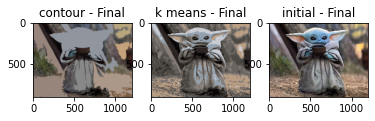

In [8]:
'''
Section 2 - Cartoonify
'''

# User input the image and will output 3 images
img = cv2.imread(r"res\yoda.jpg")

def cartoonify_a_process_img(img):

    # Reduce the noise by Gaussian Blur
    G = cv2.cvtColor(src = img, code = cv2.COLOR_BGR2GRAY)
    gaussian = cv2.GaussianBlur(G,(5,5),0)
    T = cv2.adaptiveThreshold(gaussian, maxValue = 255,
     adaptiveMethod = cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
      thresholdType = cv2.THRESH_BINARY,
       blockSize = 9,C = 5)
    bilateral = cv2.bilateralFilter(img, 9, 300, 300)
    output_img = cv2.bitwise_and(bilateral, bilateral, mask=T)

    return output_img

def cartoonify_c_find_contours(img):

    # convert the image into YUV colorspace
    YUV = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    Y = YUV[:,:,0]

    # Create a shape for morphology kernel
    shape = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))

    # Apply Clahe to the image for better contrast
    clahe = cv2.createCLAHE(clipLimit = 2, tileGridSize=(5,5))
    cl1 = clahe.apply(Y)

    # Blur the image to reduce the noise
    gaussian = cv2.GaussianBlur(src = cl1, ksize = (5,5),sigmaX = 0)

    # use dilate, opening and close of Morphology to remove any outliers
    opening = cv2.morphologyEx(gaussian, cv2.MORPH_OPEN, shape, iterations = 1)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, shape)

    # Get the threshold
    ret, threshold = cv2.threshold(closing, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Find contours
    contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    # Sort the contours from the largest to the smallest by their area
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    return contours

# Contour method
def cartoonify_c_process_img(img, contours):
    I = np.copy(img)
    for i in range(len(contours)):

        # n is the counter for the no. of pixels within the contour area.
        n = 0
        # b,g,r store values for all the pixels within the contour area.
        b,g,r = 0,0,0
        # Create an array to store location of pixels within the contour area.
        pixels = []

        # Create a rectangular box based on the contour
        x1,y1,w1,h1 = cv2.boundingRect(contours[i])

        for y_axis in range(y1,y1+h1+1):
            #print(x1,y1,w1,h1)
            for x_axis in range(x1,x1+w1+1):
                # Test whether a pixel is within the contour area, 1.0 -> inside;
                # 0.0 -> edge, -1.0 -> outside
                result = cv2.pointPolygonTest(contours[i], (x_axis,y_axis), False)

                # Get b,g,r value and store the pixel x,y value
                if result >= 0.0:
                    n = n + 1
                    b = b + I[y_axis][x_axis][0]
                    g = g + I[y_axis][x_axis][1]
                    r = r + I[y_axis][x_axis][2]
                    pixels.append([y_axis,x_axis])
        # Check if there is a valid pixel within the contour area
        if n != 0:
            # Find the average of b,g,r value
            avg_b = b / n
            avg_g = g / n
            avg_r = r / n

            # Draw the pixel with the mean value of the current contour_area
            for j in range(n):
                cv2.circle(I,(pixels[j][1],pixels[j][0],),1,(avg_b,avg_g,avg_r) )
    return I



# Colour Quantization Method
def cartoonify_k_process_img(img,K):

    Z = img.reshape((-1,3))

    # convert to np.float32
    Z = np.float32(Z)

    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((img.shape))

    return res2



fig = plt.figure()
c = cartoonify_c_find_contours(img)
output_img = cartoonify_c_process_img(img,c)

fig.add_subplot(131)
plt.imshow(cv2.cvtColor(output_img,cv2.COLOR_BGR2RGB)),plt.title('contour - Final')
#plt.show()

output_img = cartoonify_a_process_img(img)

output_img = cartoonify_k_process_img(output_img,8)
fig.add_subplot(132)
plt.imshow(cv2.cvtColor(output_img,cv2.COLOR_BGR2RGB)),plt.title('k means - Final')
#plt.show()

output_img = cartoonify_a_process_img(img)
fig.add_subplot(133)
plt.imshow(cv2.cvtColor(output_img,cv2.COLOR_BGR2RGB)),plt.title('initial - Final')
plt.show()